In [1]:
%matplotlib inline

#import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

In [2]:
# n_H = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H.npy'), "cm**-3")
# n_H2_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H2.npy'), "cm**-3")
# X_H2 = pynbody.array.SimArray(np.load('outputs/sub_grid/X_H2.npy'), "1")
# n_LW_arr = np.load('outputs/sub_grid/n_LW.npy')
# n_LW_ss_arr = np.load('outputs/sub_grid/n_LW_ss.npy')
# X_H2_ss_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/X_H2_ss.npy'), "1")
# n_H2_ss_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H2_ss.npy'), "cm**-3")
# X_CO = pynbody.array.SimArray(np.load('outputs/sub_grid/X_CO.npy'), "1")
# n_CO_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_CO.npy'), "cm**-3")
# pdf = np.load('outputs/sub_grid/pdf.npy')
# lambda_jeans = pynbody.array.SimArray(np.load('outputs/sub_grid/lambda_jeans.npy'), "cm")

In [3]:
m_p = pynbody.array.SimArray(1.672621e-24, "g")
G = pynbody.array.SimArray(6.6732e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
K_b = pynbody.array.SimArray(1.380622e-16, "g cm**2 s**-2 K**-1")
K_b_ev = pynbody.array.SimArray(8.617e-5, "eV K**-1")
K_b_erg = pynbody.array.SimArray(1.380622e-16, "erg K**-1")
c_cgs = pynbody.array.SimArray(2.9979245e10, "cm s**-1")
h_ev = pynbody.array.SimArray(4.135667e-15, "eV s")
mH_cgs = pynbody.array.SimArray(1.6735575e-24, 'g')  # hydrogen mass
eV_to_ergs = pynbody.array.SimArray(1.60218e-12, "erg eV**-1")
L_sun = pynbody.array.SimArray(3.839e33, "erg s**-1")
M_sun = pynbody.array.SimArray(2e33, "g Msol**-1")

In [4]:
n_H_mean = pynbody.array.SimArray(100., "cm**-3")
mach_no = 10
metal = 1
G_o = 2.0
x_1 = 0.4347950859536656
x_0 = 0.25201748686058306
A_10 = pynbody.array.SimArray(7.203e-08, "s**-1")
B_10 = pynbody.array.SimArray(5.10995088e-06, "cm**2 eV**-1 s**-1")
B_01 = pynbody.array.SimArray(1.53298527e-05, "cm**2 eV**-1 s**-1")
nu = pynbody.array.SimArray(1.15271202e+11, "s**-1")
energy_to_temperature_units = pynbody.array.SimArray( 1e-5*((3.24078e-19)**2)*(c_cgs/nu)**3/\
                                                     (2*K_b_erg), "K km pc**2 erg**-1")
mu = 28.0
c_s_CO = np.sqrt(K_b * T_mean/(mH_cgs*mu))
# dx = pynbody.array.SimArray(5.74179996e+20, "cm")
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize

In [5]:
def make_pdf(s, s_bar, sigma_s):
    return ((1./np.sqrt(2*np.pi*(sigma_s**2))) *
            (np.exp(-0.5*(((s - s_bar)/sigma_s)**2))))


def calc_lambda_jeans(n_H, T_mean, m_p, K_b):
    return np.asarray(np.sqrt(K_b * T_mean/m_p) /
                      np.sqrt(4.*np.pi * G * n_H * m_p))


def calc_n_LW(n_H, G_o, lambda_jeans, metal, m_p):
    kappa = 1000 * m_p * metal
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    return np.asarray(G_o * exp_tau)


def calc_X_H2(n_H, metal, n_LW):
    DC = 1.7e-11
    CC = 2.5e-17            # cm3 s-1
    numerator = DC * n_LW
    denominator = CC * metal * n_H
    X_H2 = 1. / (2. + (numerator/denominator))
    return np.asarray(2*X_H2)


def calc_n_LW_ss(n_H, n_H2, metal, G_o, lambda_jeans, m_p):
    kappa = 1000 * m_p * metal
    rad_field_outside = G_o  # in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    N_H2 = n_H2 * lambda_jeans
    term1 = pynbody.array.SimArray((0.965/((1+(N_H2/5e14))**2)), "1")
    term2 = ( (0.035/np.sqrt(1+(N_H2/5e14))) * np.exp(-1*np.sqrt(1+(N_H2/5e14))/1180) )
    S_H2 = term1 + term2
    n_LW_ss = rad_field_outside * exp_tau * S_H2
    return np.asarray(n_LW_ss)


def self_shielding_iterations(n_H, G_o, lambda_jeans, metal, m_p):
    ctr = 16
    n_LW = calc_n_LW(n_H, G_o, lambda_jeans, metal, m_p)
    X_H2 = calc_X_H2(n_H, metal, n_LW)
    n_H2 = n_H * X_H2
    n_H2_ss = n_H2
    for _ in range(ctr):
        n_LW_ss = calc_n_LW_ss(n_H, n_H2_ss, metal, G_o, lambda_jeans, m_p)
        X_H2_ss = calc_X_H2(n_H, metal, n_LW_ss)
        """
        if (np.sum(np.square(n_H2_ss - n_H * X_H2_ss)) < 1e-5):
            n_H2_ss = n_H * X_H2_ss
            break
        """
        n_H2_ss = n_H * X_H2_ss
    return n_LW, n_H2, n_LW_ss, X_H2_ss, n_H2_ss


def calc_X_CO(n_H, n_H2, n_LW):
    rate_CHX = 5.0e-10 * n_LW
    rate_CO = 1.0e-10 * n_LW
    x0 = 2.0e-4
    k0 = 5.0e-16  # cm3 s-1
    k1 = 5.0e-10  # cm3 s-1
    factor_beta = rate_CHX/(n_H*k1*x0)
    beta = 1./(1.+factor_beta)
    factor_CO = rate_CO/(n_H2*k0*beta)
    X_CO = 1./(1.+factor_CO)
    return np.asarray(X_CO)


def calc_n_CO(n_H, X_CO, metal):
    abundance_Ctot = 1e-4 # n_C/n_H as defined by nucleosynthesis
    return n_H * abundance_Ctot * metal * X_CO # CO/cc


def tau_LVG(n_CO, nu, lambda_jeans, x_1, x_0, B_10, B_01, c_s_CO, c_cgs, h_ev):
    # units: eV*s * Hz * cm * 1/cm3 * cm2/(eV*s) * 1/(Hz) = none
    delta_v = 1e5*(lambda_jeans/3.08e18)**0.5
    delta_nu_1 = c_s_CO*nu/c_cgs #"Hz"
    delta_nu_2 = delta_v*nu/c_cgs
    delta_nu_3 = (1e6*(lambda_jeans/3.08e18)**0.5)*nu/c_cgs
    tau_1 = h_ev*nu*lambda_jeans*n_CO*((x_0*B_01)-(x_1*B_10))/(4*np.pi*delta_nu_1)
    tau_2 = h_ev*nu*lambda_jeans*n_CO*((x_0*B_01)-(x_1*B_10))/(4*np.pi*delta_nu_2)
    tau_3 = h_ev*nu*lambda_jeans*n_CO*((x_0*B_01)-(x_1*B_10))/(4*np.pi*delta_nu_3)
    return np.asarray(tau_1), np.asarray(tau_2), np.asarray(tau_3)
 
    
def beta_LVG(tau):
    beta_lvg = np.zeros(len(tau))
    for i in range(0, len(tau)):
        if tau[i] < 0.01:
            beta_lvg[i] = 1. - tau[i]/2.
        elif tau[i] > 100.:
            beta_lvg[i] = 1./tau[i]
        else:
            beta_lvg[i] = (1.0 - np.exp(-tau[i])) / tau[i]
    return beta_lvg


def calc_integrated_emissivity(n_CO, nu, x_1, A_10, h_ev):
    #units: eV*s * Hz * cm-3 * s-1 = eV/cm3/s
    j_10 = h_ev * nu * n_CO * x_1 * A_10
    return j_10

In [6]:
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar

s = np.linspace(smin, smax, num=100, endpoint=False)
ds = np.diff(s)[0]
pdf = make_pdf(s, s_bar, sigma_s)

n_H = n_H_mean * np.exp(s)
lambda_jeans = calc_lambda_jeans(n_H, T_mean, m_p, K_b)

ctr = 16
n_LW = calc_n_LW(n_H, G_o, lambda_jeans, metal, m_p)
X_H2 = calc_X_H2(n_H, metal, n_LW)
n_H2 = n_H * X_H2
n_H2_ss = n_H2
for _ in range(ctr):
    n_LW_ss = calc_n_LW_ss(n_H, n_H2_ss, metal, G_o, lambda_jeans, m_p)
    X_H2_ss = calc_X_H2(n_H, metal, n_LW_ss)
    """
    if (np.sum(np.square(n_H2_ss - n_H * X_H2_ss)) < 1e-5):
        n_H2_ss = n_H * X_H2_ss
        break
    """
    n_H2_ss = n_H * X_H2_ss

X_CO = calc_X_CO(n_H, n_H2, n_LW)
n_CO = calc_n_CO(n_H, X_CO, metal)
tau_nu_1, tau_nu_2, tau_nu_3 = tau_LVG(n_CO, nu, lambda_jeans, x_1, x_0, 
                     B_10, B_01, c_s_CO, c_cgs, h_ev)
beta_nu_1 = beta_LVG(tau_nu_1) #sound speed
beta_nu_2 = beta_LVG(tau_nu_2) #1e5
beta_nu_3 = beta_LVG(tau_nu_3) #1e6
j_10 = calc_integrated_emissivity(n_CO, nu, x_1, A_10, h_ev)  # eV/cm3/s
# m_H2 = m_p * (dx**3) * X_H2_ss  #g cm3
l_CO_1 = j_10 * beta_nu_1 * eV_to_ergs * M_sun  #ergs g/cm3/s/M_sol
l_CO_2 = j_10 * beta_nu_2 * eV_to_ergs * M_sun  #ergs g/cm3/s/M_sol
l_CO_3 = j_10 * beta_nu_3 * eV_to_ergs * M_sun  #ergs g/cm3/s/M_sol

l_CO_SI_1 = j_10 * beta_nu_1 * eV_to_ergs * M_sun * energy_to_temperature_units # K km s-1 pc2 M_sol-1 g cm-3
l_CO_SI_2 = j_10 * beta_nu_2 * eV_to_ergs * M_sun * energy_to_temperature_units # K km s-1 pc2 M_sol-1 g cm-3
l_CO_SI_3 = j_10 * beta_nu_3 * eV_to_ergs * M_sun * energy_to_temperature_units # K km s-1 pc2 M_sol-1 g cm-3
# the g cm-3 in the units of l_CO_SI_1, l_CO_SI_2, l_CO_SI_3 will cancel when we go to 
# the plotting where we plot l_CO_SI_1/m_p/n_H

In [7]:
eV_to_ergs*h_ev*nu*1e-4*x_1*A_10*1/m_p

SimArray(0.00143014, 'erg s**-1 g**-1')

In [8]:
eV_to_ergs*h_ev*nu*1e-4*x_1*A_10*1*energy_to_temperature_units*M_sun/m_p

SimArray(191.38244835, 'pc**2 K km Msol**-1 s**-1')

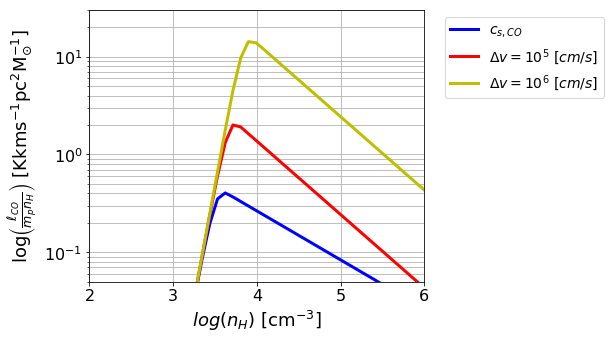

In [67]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.semilogy(np.log10(n_H), l_CO_SI_1/m_p/n_H, c="b", lw=3, label="$c_{s, CO}$")
plt.semilogy(np.log10(n_H), l_CO_SI_2/m_p/n_H, c="r", lw=3, label="$\Delta v=10^5\ [cm/s]$")
plt.semilogy(np.log10(n_H), l_CO_SI_3/m_p/n_H, c="y", lw=3, label="$\Delta v=10^6\ [cm/s]$")
# plt.yscale("log")
# ax.set_ylim([-6,1])
# ax.set_xlim([2, 6])
ax.set_ylim([5e-2,3e1])
ax.set_xlim([2.0, 6])
ax.set_ylabel(r'$\log\left(\frac{\ell_{CO}}{m_p n_H}\right) \ [\rm{K km s^{-1} pc^{2} M_{\odot}^{-1}}] $')
plt.xlabel(r'$log({n_H}) \ [\rm{cm^{-3}}]$')
plt.grid(b=True, which='both', axis='both')
legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]
# plt.title("$log(n_{H})$ vs $beta$")
plt.savefig('outputs/for_thesis/log(n_H)vsl_CO_SI-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

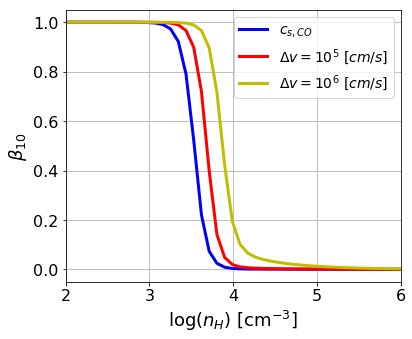

In [68]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), beta_nu_1, c="b", lw=3, label="$c_{s, CO}$")
plt.plot(np.log10(n_H), beta_nu_2, c="r", lw=3, label="$\Delta v=10^5\ [cm/s]$")
plt.plot(np.log10(n_H), beta_nu_3, c="y", lw=3, label="$\Delta v=10^6\ [cm/s]$")
# ax.set_ylim([-6,1])
ax.set_xlim([2, 6])
ax.set_ylabel(r'$\beta_{1 0}$')
plt.xlabel(r'$\log({n_H}) \ [\rm{cm^{-3}}]$')
plt.grid(b=True, which='both', axis='both')
plt.rc('legend', fontsize=14)    # legend fontsize
legend = plt.legend(loc="upper right")
legend.legendHandles[0]._sizes = [20]
legend.legendHandles[1]._sizes = [20]
legend.legendHandles[2]._sizes = [20]
# plt.title("$log(n_{H})$ vs $beta$")
plt.savefig('outputs/for_thesis/log(n_H)vsbeta-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

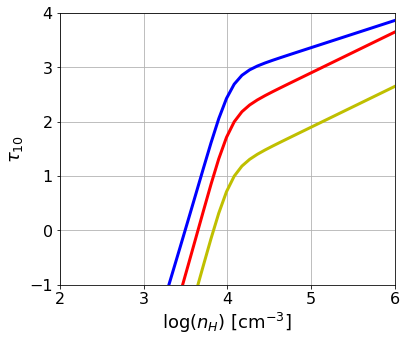

In [93]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), np.log10(tau_nu_1), c="b", lw=3, label="$c_{s, CO}$")
plt.plot(np.log10(n_H), np.log10(tau_nu_2), c="r", lw=3, label="$\Delta v=10^5\ [cm/s]$")
plt.plot(np.log10(n_H), np.log10(tau_nu_3), c="y", lw=3, label="$\Delta v=10^6\ [cm/s]$")
ax.set_ylim([-1,4])
ax.set_xlim([2, 6])
ax.set_ylabel(r'$\tau_{1 0}$')
# plt.ylabel('$log(tau)$')
plt.xlabel(r'$\log({n_H}) \ [\rm{cm^{-3}}]$')
plt.grid(b=True, which='both', axis='both')
# legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# legend.legendHandles[0]._sizes = [30]
# legend.legendHandles[1]._sizes = [30]
# legend.legendHandles[2]._sizes = [30]
# plt.title("$log(n_{H})$ vs $log(tau)$")
plt.savefig('outputs/for_thesis/log(n_H)vslog(tau)-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

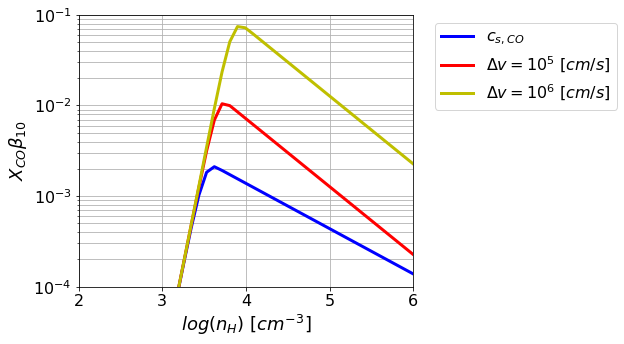

In [19]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.semilogy(np.log10(n_H), X_CO*beta_nu_1, c="b", lw=3, label="$c_{s, CO}$")
plt.semilogy(np.log10(n_H), X_CO*beta_nu_2, c="r", lw=3, label="$\Delta v=10^5\ [cm/s]$")
plt.semilogy(np.log10(n_H), X_CO*beta_nu_3, c="y", lw=3, label="$\Delta v=10^6\ [cm/s]$")
ax.set_ylim([1e-4,1e-1])
# ax.set_ylim([-4, -1])
ax.set_xlim([2.0, 6])
# plt.yscale("log")
plt.xlabel('$log(n_{H}) \ [cm^{-3}]$')
ax.set_ylabel(r'$X_{CO} \beta_{1 0}$')
# plt.ylabel('$X_{CO}\cdot beta$')
plt.grid(b=True, which='both', axis='both')
legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]
# plt.title("$log(n_{H})$ vs $X_{CO}\cdot beta$ - zoomed in")
plt.savefig('outputs/for_thesis/log(n_H)vsX_CO_beta-zoomed-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

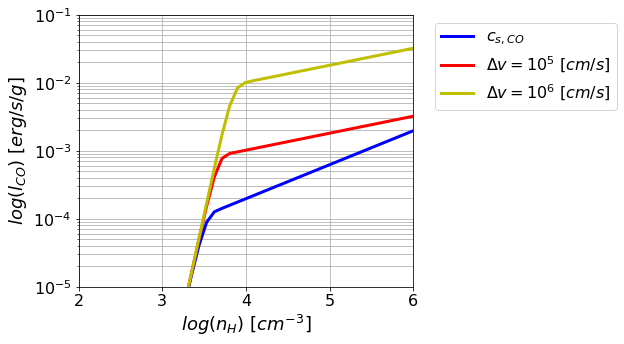

In [20]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.semilogy(np.log10(n_H), l_CO_1/m_p/n_H_mean, c="b", lw=3, label="$c_{s, CO}$")
plt.semilogy(np.log10(n_H), l_CO_2/m_p/n_H_mean, c="r", lw=3, label="$\Delta v=10^5\ [cm/s]$")
plt.semilogy(np.log10(n_H), l_CO_3/m_p/n_H_mean, c="y", lw=3, label="$\Delta v=10^6\ [cm/s]$")
# plt.yscale("log")
# ax.set_ylim([-6,1])
# ax.set_xlim([2, 6])
ax.set_ylim([1e-5,1e-1])
ax.set_xlim([2.0, 6])
ax.set_ylabel('$log(l_{CO}) \ [erg s^{-1} M_{\odot}^{-1}]$')
plt.xlabel('$log({n_H}) \ [cm^{-3}]$')
plt.grid(b=True, which='both', axis='both')
legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]
# plt.title("$log(n_{H})$ vs $beta$")
plt.savefig('outputs/for_thesis/log(n_H)vsl_CO-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

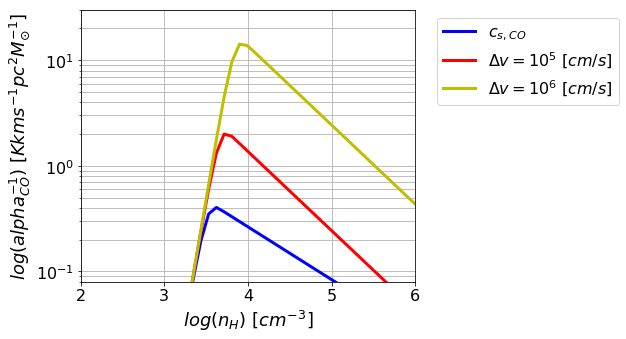

In [13]:
alpha_1_SI = l_CO_SI_1/(n_H*m_p) #[K km s**-1 pc**2 Msol**-1]
alpha_2_SI = l_CO_SI_2/(n_H*m_p) #[K km s**-1 pc**2 Msol**-1]
alpha_3_SI = l_CO_SI_3/(n_H*m_p) #[K km s**-1 pc**2 Msol**-1]

plt.figure(figsize=(6,5))
ax = plt.gca()
plt.semilogy(np.log10(n_H), alpha_1_SI, c="b", lw=3, label="$c_{s, CO}$")
plt.semilogy(np.log10(n_H), alpha_2_SI, c="r", lw=3, label="$\Delta v=10^5\ [cm/s]$")
plt.semilogy(np.log10(n_H), alpha_3_SI, c="y", lw=3, label="$\Delta v=10^6\ [cm/s]$")
# plt.yscale("log")
# ax.set_ylim([-6,1])
# ax.set_xlim([2, 6])
ax.set_ylim([8e-2,3e1])
ax.set_xlim([2.0, 6])
ax.set_ylabel('$log(alpha_{CO}^{-1}) \ [K km s^{-1} pc^{2} M_{\odot}^{-1}] $')
plt.xlabel('$log({n_H}) \ [cm^{-3}]$')
plt.grid(b=True, which='both', axis='both')
legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]
# plt.title("$log(n_{H})$ vs $beta$")
plt.savefig('outputs/for_thesis/log(n_H)vsalpha_CO_SI-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

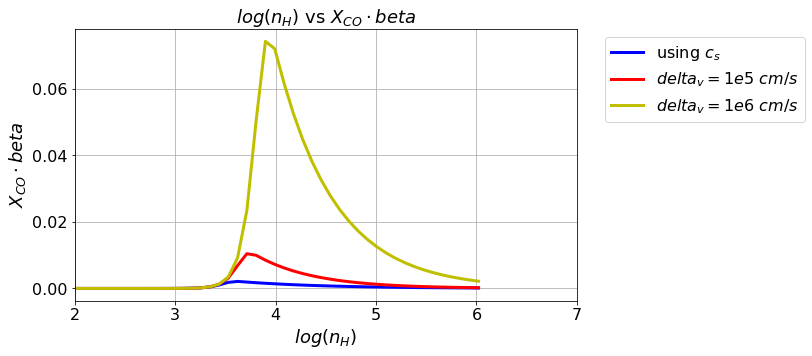

In [11]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.plot(np.log10(n_H), X_CO*beta_nu_1, c="b", lw=3, label="using $c_s$")
plt.plot(np.log10(n_H), X_CO*beta_nu_2, c="r", lw=3, label="$delta_{v}=1e5\ cm/s$")
plt.plot(np.log10(n_H), X_CO*beta_nu_3, c="y", lw=3, label="$delta_{v}=1e6\ cm/s$")
# ax.set_ylim([-6,1])
ax.set_xlim([2, 7])
plt.ylabel('$X_{CO}\cdot beta$')
plt.xlabel('$log({n_H})$')
plt.grid(b=True, which='both', axis='both')
legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]
plt.title("$log(n_{H})$ vs $X_{CO}\cdot beta$")
plt.savefig('outputs/sub_grid/log(n_H)vsX_CO_beta-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

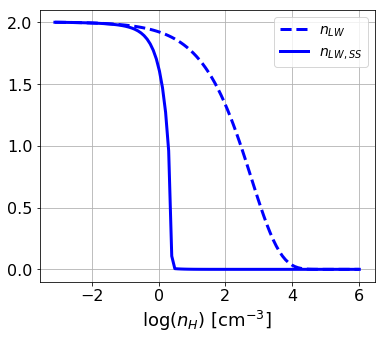

In [70]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), n_LW, c="b", lw=3, ls='--', label="$n_{LW}$")
plt.plot(np.log10(n_H), n_LW_ss, c="b", lw=3, label="$n_{LW, SS}$")
# ax.set_ylim([-6,1])
# ax.set_xlim([-1.65, 3])
plt.xlabel(r'$\log({n_H}) \ [\rm{cm^{-3}}]$')
plt.grid(b=True, which='both', axis='both')
plt.legend()
plt.savefig('outputs/for_thesis/log(n_H)vsn_LW-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

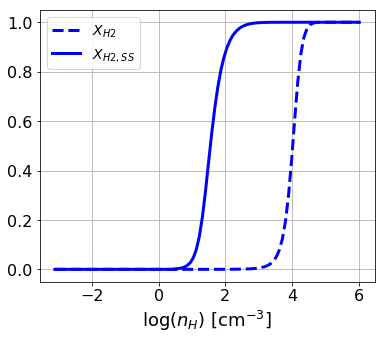

In [71]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), X_H2, c="b", lw=3, ls='--', label="$X_{H2}$")
plt.plot(np.log10(n_H), X_H2_ss, c="b", lw=3, label="$X_{H2, SS}$")
# plt.plot(np.log10(n_H), X_CO, c="r", lw=3, ls=':')
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel(r'$\log({n_H}) \ [\rm{cm^{-3}}]$')
# plt.ylabel('$X_{H2}$')
plt.grid(b=True, which='both', axis='both')
plt.legend()
# plt.title("$log(n_{H})$ vs $X_{H2}$")
plt.savefig('outputs/for_thesis/log(n_H)vsX_H2-comp.png', 
            dpi=300, bbox_inches='tight')
plt.show()

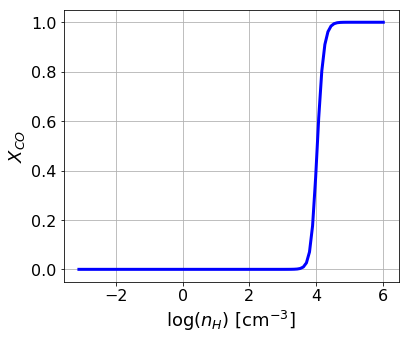

In [72]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), X_CO, c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel(r'$\log({n_H}) \ [\rm{cm^{-3}}]$')
plt.ylabel('$X_{CO}$')
plt.grid(b=True, which='both', axis='both')
# plt.title("$log(n_{H})$ vs $X_{CO}$")
plt.savefig('outputs/for_thesis/log(n_H)vsX_CO.png', 
            dpi=300, bbox_inches='tight')
plt.show()

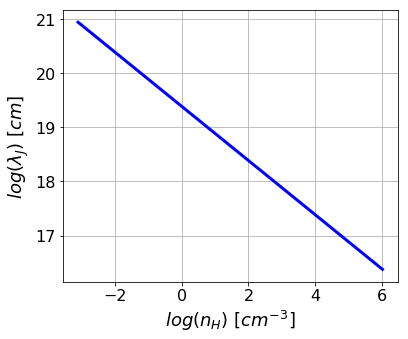

In [26]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), np.log10(lambda_jeans), c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-1.65, 3])
plt.xlabel('$log(n_{H}) \ [cm^{-3}]$')
plt.ylabel('$log(\lambda_{J}) \ [cm]$')
plt.grid(b=True, which='both', axis='both')
# plt.title("$log(n_{H})$ vs $log(\lambda_{Jeans}) \ (cm)$")
plt.savefig('outputs/for_thesis/log(n_H)vslog(lambda_jeans).png', 
            dpi=300, bbox_inches='tight')
plt.show()

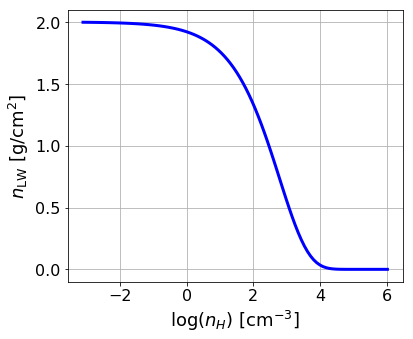

In [12]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), n_LW, c="b", lw=3)
ax.set_xlabel(r'$\log({n_H}) \ [\rm{cm^{-3}}]$')
ax.set_ylabel(r'$n_{\rm{LW}} \ [\rm{g/cm^{2}}]$')
plt.grid(b=True, which='both', axis='both')
plt.savefig('outputs/for_thesis/log(n_H)vsn_LW-comp-withoutSS.png', 
            dpi=300, bbox_inches='tight')
plt.show()

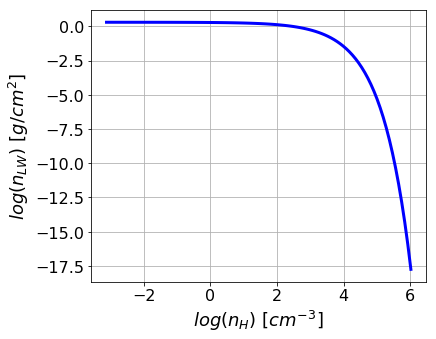

In [68]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), np.log10(n_LW), c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-1.65, 3])
plt.xlabel('$log(n_{H}) \ [cm^{-3}]$')
plt.ylabel('$log(n_{LW}) \ [g/cm^{2}]$')
plt.grid(b=True, which='both', axis='both')
plt.savefig('outputs/for_thesis/log(n_H)vslog(n_LW).png', 
            dpi=300, bbox_inches='tight')
plt.show()

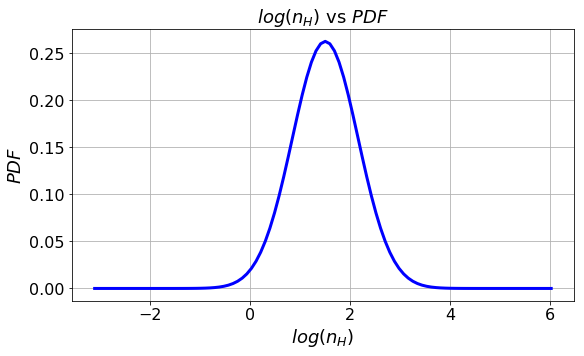

In [17]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.plot(np.log10(n_H), pdf, c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel('$log(n_{H})$')
plt.ylabel('$PDF$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H})$ vs $PDF$")
plt.savefig('outputs/sub_grid/log(n_H)vsPDF.png', 
            dpi=300, bbox_inches='tight')
plt.show()

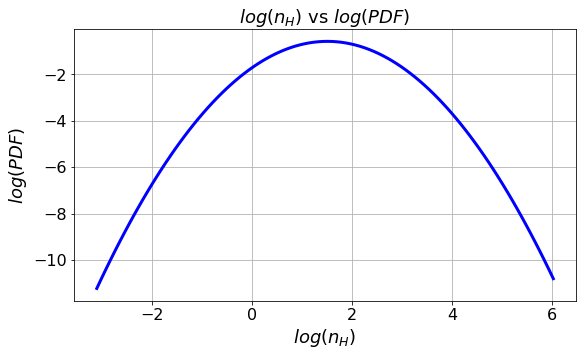

In [18]:
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.plot(np.log10(n_H), np.log10(pdf), c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel('$log(n_{H})$')
plt.ylabel('$log(PDF)$')
plt.grid(b=True, which='both', axis='both')
plt.title("$log(n_{H})$ vs $log(PDF)$")
plt.savefig('outputs/sub_grid/log(n_H)vslog(PDF).png', 
            dpi=300, bbox_inches='tight')
plt.show()

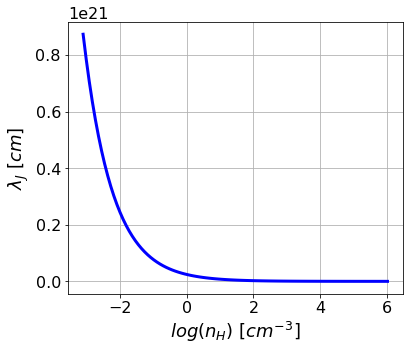

In [15]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), lambda_jeans, c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-3,3])
plt.xlabel('$log(n_{H}) \ [cm^{-3}]$')
plt.ylabel('$\lambda_{J} \ [cm]$')
plt.grid(b=True, which='both', axis='both')
# plt.title("$log(n_{H})$ vs $\lambda_{Jeans} \ (cm)$")
plt.savefig('outputs/for_thesis/log(n_H)vslambda_jeans.png', 
            dpi=300, bbox_inches='tight')
plt.show()

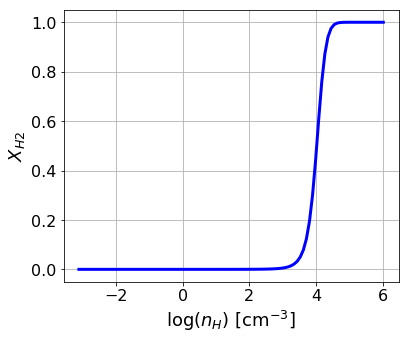

In [13]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), X_H2, c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
ax.set_xlabel(r'$\log({n_H}) \ [\rm{cm^{-3}}]$')
ax.set_ylabel(r'$X_{H2}$')
plt.grid(b=True, which='both', axis='both')
# plt.title("$log(n_{H})$ vs $X_{H2}$")
plt.savefig('outputs/for_thesis/log(n_H)vsX_H2_withoutSS.png', 
            dpi=300, bbox_inches='tight')
plt.show()

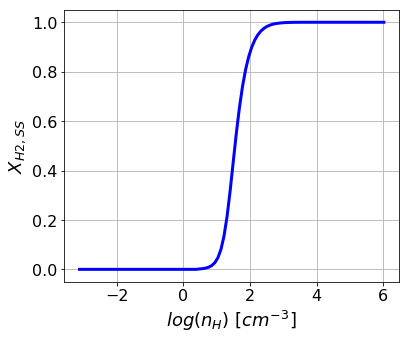

In [21]:
plt.figure(figsize=(6,5))
ax = plt.gca()
plt.plot(np.log10(n_H), X_H2_ss, c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.xlabel('$log(n_{H}) \ [cm^{-3}]$')
plt.ylabel('$X_{H2, SS}$')
plt.grid(b=True, which='both', axis='both')
# plt.title("$log(n_{H})$ vs $X_{H2, SS}$")
plt.savefig('outputs/for_thesis/log(n_H)vsX_H2_ss.png', 
            dpi=300, bbox_inches='tight')
plt.show()

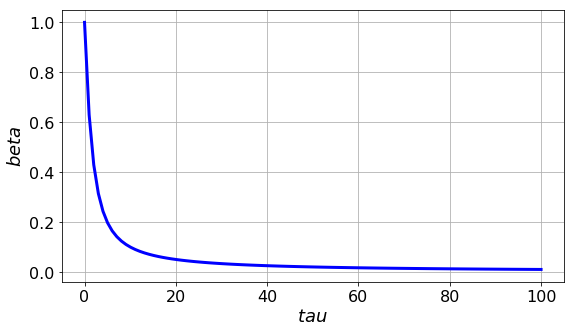

In [24]:
foo = np.linspace(0, 100, 100)
bar = beta_LVG(foo)
plt.figure(figsize=(9,5))
ax = plt.gca()
plt.plot(foo, bar, c="b", lw=3)
# ax.set_ylim([-6,1])
# ax.set_xlim([-1, 3])
plt.ylabel('$beta$')
plt.xlabel('$tau$')
plt.grid(b=True, which='both', axis='both')
# plt.title("$log(n_{H})$ vs $X_{CO}$")
# plt.savefig('outputs/sub_grid/log(n_H)vsX_CO.png', 
#             dpi=300, bbox_inches='tight')
plt.show()